# Malaria Detection

A deep learning model classifying whether if a person is diagnosed with malaria.

**Datasets**: [Malaria datasets](https://www.tensorflow.org/datasets/catalog/malaria)

---

## Dependencies

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer

---

## Importing Dataset

Loading the malaria dataset in using `tensorflow_datasets`.
* This dataset has only **train**, it is required to manually split the data.

In [2]:
train_dataset, train_dataset_info = tfds.load('malaria', 
                                    with_info=True, 
                                    as_supervised=True, 
                                    shuffle_files=True, 
                                    split=['train'])

Checking the loaded train dataset.

In [3]:
train_dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
for train_data in train_dataset[0].take(1): # Taking 1 data snapshot
    print(train_data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [5]:
len(train_dataset[0])

27558

There are total of **27,558** training images.

### Splitting the dataset

In [6]:
dataset_info = train_dataset_info

In [7]:
def split_dataset(dataset:tf.data.Dataset, TRAIN_SPLIT:int, VAL_SPLIT:int, TEST_SPLIT:int) -> Tuple:
    dataset_len = len(dataset)

    train_dataset = dataset.take(int(TRAIN_SPLIT*dataset_len))

    # Skipping the part assigned for train dataset
    val_test_dataset = dataset.skip(int(TRAIN_SPLIT*dataset_len))

    val_dataset = val_test_dataset.take(int(VAL_SPLIT*dataset_len))

    test_dataset = val_test_dataset.skip(int(VAL_SPLIT*dataset_len))
    
    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = split_dataset(train_dataset[0], 0.8, 0.1, 0.1)

print(len(list(train_dataset.as_numpy_iterator())), 
      len(list(val_dataset.as_numpy_iterator())), 
      len(list(test_dataset.as_numpy_iterator())))

22046 2755 2757


---

## Visualising Dataset

Viewing *dataset_info* to retrieve useful image attributes.

In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\linta\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

Plotting 16 datasets for visualisation purposes.

Label [0] - parasitized
Label [1] - uninfected


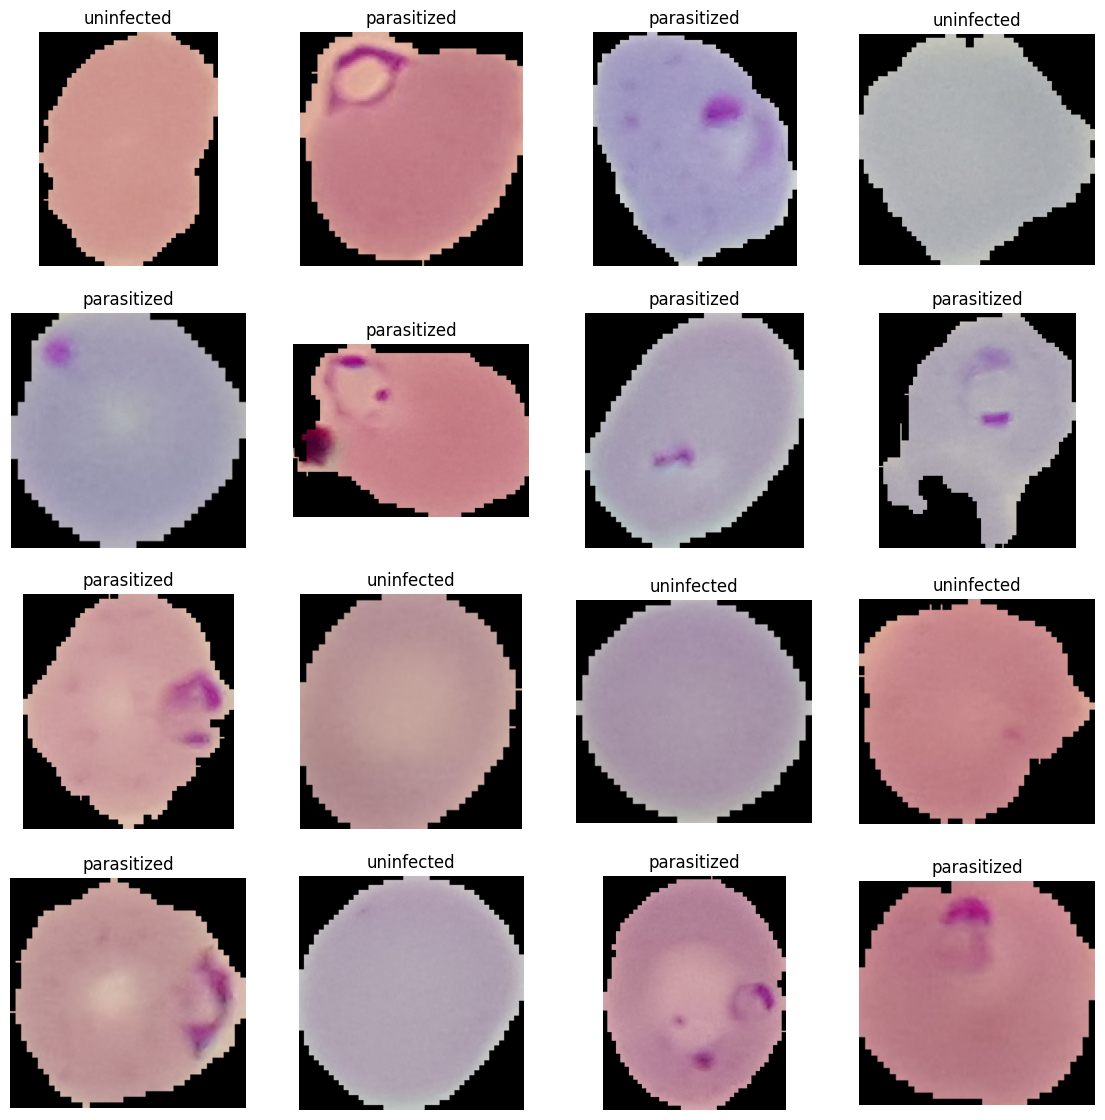

In [10]:
plt.figure(figsize=(14, 14))

for idx, (img, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, idx+1)
    plt.imshow(img)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis(False)
    
print(f"Label [0] - {dataset_info.features['label'].int2str(0)}")
print(f"Label [1] - {dataset_info.features['label'].int2str(1)}")

---

## Data Preprocessing

1. Fixing the images to fixed sizes: **224 x 224**.

2. Normalising the images.
    * For images where most of pixels are at around at **particular mean value** -> Standardisation
    * For images where most of pixels are **mostly different** -> Normalisation

### Resizing and normalising the image data

In [16]:
def preprocess_img(img, label, resize_H=224, resize_W=224):
    return tf.image.resize(img, (resize_H, resize_W))/255.0, label

In [17]:
train_dataset = train_dataset.map(resize_img)

In [18]:
for img, label in train_dataset.take(1):
    print(img, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


The shape is now **(224, 224, 3)**.

---

## Training Preparation

### Setting up the intial model

Initially setting up the model as LeNet architecture.
* For experiment purposes.

In [23]:
model = tf.keras.Sequential([InputLayer(input_shape=(224, 224, 3)),
                             Conv2D(filters=6,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='sigmoid'),
                             MaxPool2D(pool_size=2, strides=2),
                             
                             Conv2D(filters=16,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='sigmoid'),
                             MaxPool2D(pool_size=2, strides=2),
                             
                             Flatten(),
                             
                             Dense(100, activation='sigmoid'),
                             Dense(10, activation='sigmoid'),
                             Dense(2, activation='sigmoid'),
                             ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 44944)             0         
                                                                 
 dense_3 (Dense)             (None, 100)              